In [1]:
!pip3 install feature-engine


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: /usr/local/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for the model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

# for feature engineering
from feature_engine import imputation as mdi
from feature_engine import encoding as ce

In [2]:
data =pd.read_csv('../dataset/train.csv',index_col='Id')
target = "SalePrice"

In [3]:
#remover colunas com mais de 50% de valores faltantes:
# check missing values:
missing_values = pd.DataFrame(data={
    'Feature_name': data.columns,
    'missing_values': data.isnull().sum(),
    'percentage': data.isnull().sum() / len(data) * 100,
    'type': data.dtypes
})
features_to_drop = missing_values[missing_values['percentage'] > 50]['Feature_name'].values
data = data.drop(features_to_drop, axis='columns')

In [4]:
# get numerical features correlated with the target
numerical_features = data.select_dtypes(exclude=['object']).columns
corr = data[numerical_features].corr()
corr_target = abs(corr[target])
relevant_features = corr_target[corr_target > 0.5]
numerical_features = relevant_features.index

# drop less correlated numerical features
less_correlated_features = set(data.select_dtypes(include=[np.number]).columns) - set(numerical_features)
data = data.drop(less_correlated_features, axis='columns')

In [5]:
# make list of variables types
# we need these lists to indicate Feature-engine which variables it should modify

# numerical: discrete
discrete = [
    var for var in data.columns if data[var].dtype != 'O' and var != target
    and data[var].nunique() < 16
]

# numerical: continuous
continuous = [
    var for var in data.columns
    if data[var].dtype != 'O' and var != target and var not in discrete
]

# categorical
categorical = [var for var in data.columns if data[var].dtype == 'O' and data[var].nunique() > 1]

print('There are {} discrete variables'.format(len(discrete)))
print('There are {} continuous variables'.format(len(continuous)))
print('There are {} categorical variables'.format(len(categorical)))

There are 4 discrete variables
There are 6 continuous variables
There are 38 categorical variables


In [23]:
data[categorical]

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
4,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,WD,Abnorml
5,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,...,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
1457,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,...,TA,Min1,TA,Attchd,Unf,TA,TA,Y,WD,Normal
1458,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,...,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,WD,Normal


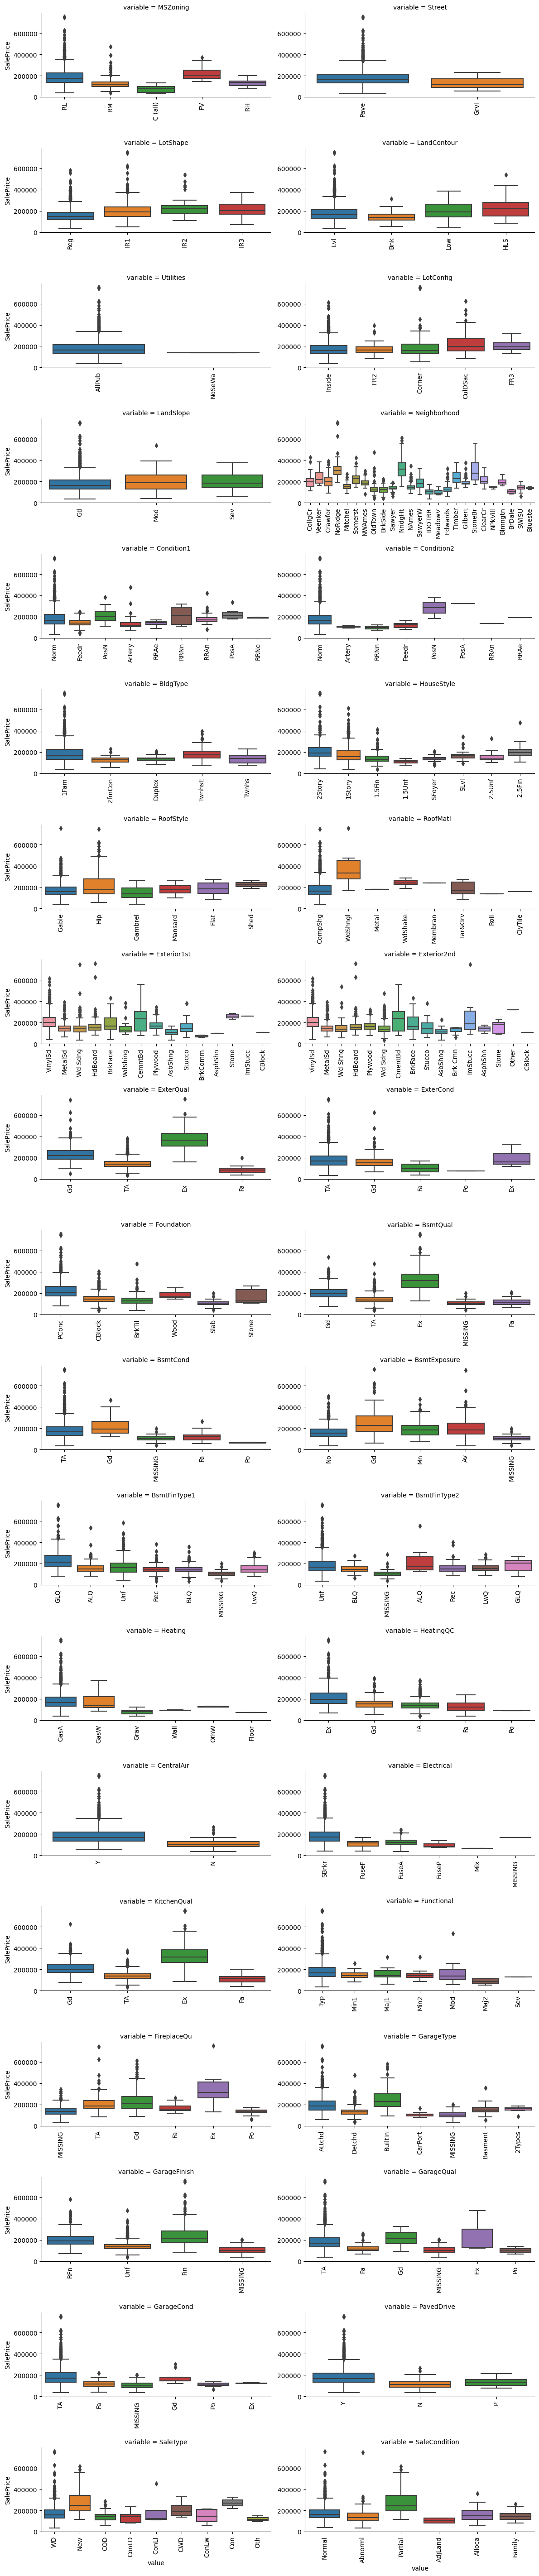

In [26]:
import seaborn as sns
for c in categorical:
    data[c] = data[c].astype('category')
    if data[c].isnull().any():
        data[c] = data[c].cat.add_categories(['MISSING'])
        data[c] = data[c].fillna('MISSING')

def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
f = pd.melt(data, id_vars=['SalePrice'], value_vars=categorical)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False,aspect=2)
g = g.map(boxplot, "value", "SalePrice")

In [22]:
continuous.remove('GarageArea')
continuous.remove('1stFlrSF')
continuous.remove('GrLivArea')
continuous

['YearBuilt', 'YearRemodAdd', 'TotalBsmtSF']

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split

<Axes: >

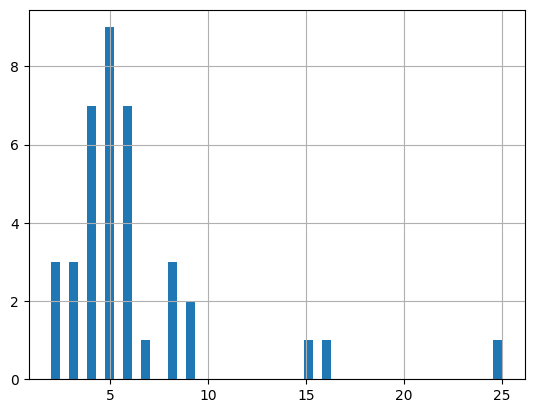

In [10]:
data[categorical].nunique().hist(bins=50)

In [14]:
# separate into training and testing set
X = data.drop([target], axis=1).copy()
Y = data[target] # here we need to remove unnacessary columns if exist
X_train, X_test, y_train, y_test = train_test_split(
    X,  # predictors
   Y,  # target
    test_size=0.1,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1314, 48), (146, 48))

In [29]:
# from sklearn.feature_selection import mutual_info_regression
# mi = mutual_info_regression(X_train, y_train)

# # and make a bar  plot
# mi = pd.Series(mi)
# mi.index = X_train.columns
# mi.sort_values(ascending=False).plot.bar(figsize=(20,6))
# plt.ylabel('Mutual Information')

In [15]:
feature_engineer_pipeline = Pipeline([

    # missing data imputation - we replace na in numerical variables
    # with an arbitrary value. 
    ('imputer_num',
     mdi.ArbitraryNumberImputer(arbitrary_number=-1,
                                variables=continuous)),
    
    # for categorical variables, we can either replace na with the string
    # missing or with the most frequent category
    ('imputer_cat',
     mdi.CategoricalImputer(variables=categorical)),

    # categorical encoding - we will group rare categories into 1
    ('encoder_rare_label', ce.RareLabelEncoder(
        tol=0.01,
        n_categories=6,
        variables=categorical,
    )),
    
    # we replace category names by numbers
    ('categorical_encoder', ce.OrdinalEncoder(
        encoding_method='ordered',
        variables=categorical,
    )),

    # Gradient Boosted machine
    ('gbm', GradientBoostingClassifier(random_state=0))
])

In [16]:
# now we create the hyperparameter space that we want to sample
# that is, the hyperparameter values that we want to test.

# to perform Grid search, we need to specifically provide the hyperparameter
# values that we want to test

# to opimize hyperparameters within a pipeline, we assemble the space
# as follows:

param_grid = {
    # try different feature engineering parameters:
    
    # test different parameters to replace na with numbers
    'imputer_num__arbitrary_number': [-1, 2],
    
    # test imputation with frequent category or string missing
    'imputer_cat__imputation_method': ['missing','frequent'],
    
    # test different thresholds to group rare labels
    'encoder_rare_label__tol': [0.1, 0.2],
    
    # test 2 different encoding strategies
    'categorical_encoder__encoding_method': ['ordered', 'arbitrary'],
    
    # try different gradient boosted tree model paramenters
    'gbm__max_depth': [None, 1, 3],
    'gbm__n_estimators': [20, 50, 100]
}

# (note how we call the step name in the pipeline followed by __
# followed by the name of the hyperparameter that we want to modify)

# for more details on the Feature-engine transformers hyperparameters, visit
# Feature-engine documentation

In [17]:
grid_search = GridSearchCV(
    feature_engineer_pipeline, # the pipeline
    param_grid, # the hyperparameter space
    cv=3, # the cross-validation
    scoring='neg_root_mean_squared_error', # the metric to optimize
)

# and now we train over all the possible combinations of the parameters
# specified above
grid_search.fit(X_train, y_train)

# and we print the best score over the train set
print(("best RMSE from grid search: %.3f"
       % -grid_search.score(X_train, y_train)))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable MSZoning is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable Street is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories f

KeyboardInterrupt: 

In [88]:
print('SalePrice' in X_train.columns)

False


In [26]:
missing_values.loc[discrete, :]

,Feature_name,missing_values,percentage,type
OverallCond,GarageArea,0.0,0.0,int64
BsmtFullBath,Condition1,0.0,0.0,int64
BsmtHalfBath,Condition2,0.0,0.0,int64
FullBath,BsmtQual,0.0,0.0,int64
HalfBath,HeatingQC,0.0,0.0,int64
BedroomAbvGr,Street,0.0,0.0,int64
KitchenAbvGr,2ndFlrSF,0.0,0.0,int64
GarageCars,BsmtFinType1,0.0,0.0,int64
PoolArea,PavedDrive,0.0,0.0,int64
YrSold,SalePrice,0.0,0.0,int64


In [28]:
#select continuous variables with missing data
missing_values.loc[continuous, :].loc[missing_values.loc[continuous, :]['missing_values'] > 0, :]

,Feature_name,missing_values,percentage,type
LotFrontage,HalfBath,259.0,17.739726,float64
GarageYrBlt,TotalBsmtSF,81.0,5.547945,float64


In [31]:
missing_values.loc[categorical, :].loc[missing_values.loc[categorical, :]['missing_values'] > 0, :].index

Index(['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'],
      dtype='object')